# CSCI 567 Project

In [5]:
"""
Notes:
- GarageType variable might be biased. Note that it has a 2types variable making our dummy variables technically incorrect since we dont know which 2 types it is
- PavedDrive: It could be argued that this variable should be numerically categorized rather than turned into dummy variables
"""

'\nNotes:\n- GarageType variable might be biased. Note that it has a 2types variable making our dummy variables technically incorrect since we dont know which 2 types it is\n- PavedDrive: It could be argued that this variable should be numerically categorized rather than turned into dummy variables\n'

In [6]:
import numpy as np
import pandas as pd
import math

import os

In [7]:
# SET ENV VARIABLES
train_csv = 'train.csv'
test_csv = 'test.csv'

In [8]:
# Read CSV
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

train_df_orig, test_df_orig = train_df, test_df
test_df.shape

(1459, 80)

In [9]:
# Note the difference between columns in train_df and test_df
test_df = test_df[set(train_df.columns).intersection(set(test_df.columns))]

When reviewing the housing dataset, we noticed several changes to existing features that would need to be preproccessed before being able to train a model.

##### Integer/Float-based Variables
Many features provided by the train dataset were in integer or float form. Many of these features provided the size (area) of rooms or the number of specific amenities like "fireplaces". These features being in numerical form allow us to keep most of them as its numerical value, only needing to normalize the values. There are some exceptions such as "MSSubClass" which, while having numerical values, should be treated as a categorical feature.

##### Relative Categorical Variables
The first type of feature that needed preprocessing was relative categroical values. Relative categorical variables are categorical variables that have some relation to each other. For example, the basement quality ("bsmtQual") feature has string values "Po", "Fa", "TA", "Gd", "Ex", representing the overall qualtiy of the basement. While we could treat this like a normal categorical variable, creating a dummy variable for each category type, this strategy would not take into account that a "Fa" (Fair) rating is more similar to "Po" (Poor) than an "Ex" (Excellent) rating. As a result, we opted to replace these values to numerical values 1 through 5, to preserve the relationship between categories. 

##### Categorical Variables
The second type of variable that needed preprocessing were normal categorical variables. After converting all the relative categrocial variables to integer values, we were able to automatically convert any other "string" or "object" type features in the dataset to dummy variables. Examples of the remaining categorical variables were "Foundation" and "Heating". For these remaining features, we converted each category into its own feature, giving the value a 1 if the sample was from that category and a 0 otherwise. This step increased the number of features in our dataset, though the number of unique categories for the remaining features is limited so this does not drastically affect the total number of features.

##### Disproportionate Categorical Variables
To minimize the number of unique features we create, we examined the categorical variables to see if we could find any trends. We found two categories, electrical and BsmtFinType2. We found that these categories were disprotionately "SBrkr" and "Unf" respectively. As a result, for these categories, we converted the feature to be 1 when its disproportionate category and 0 otherwise.

##### Cyclical Variables
We noticed that the Month Sold variable was a cyclical variable. While we could categorize each month into an integer, the model would assume that January and December are opposites, even though they are just one month apart. As a reuslt, we converted this feature into two features, the sine and cosine of the normalized value of the month. By doing so, we can use both features together to correctly model the relationship of months. This solution does have its limitations on models that consider only one feature at a time like Random Forest classifiers. This will be considered as we design our models.

##### Missing Values
Some features have NA values for some fields. We decided to resolve this issue with the by replacing NA values with  the average of all available values for that field in the training set. Assuming that the training and test set are  independent and identically distributed, using the same average for missing values in the test set should not lead to any issues. Unfortunately, using the average value for relative categorical variables (see above) is less than ideal since the average value does not necessarily give a good indiciation for the missing value. As a result, we add an extra feature for categorical variables that can be NA which is 1 of the value is NA and 0 if not, allowing the model to potentially learn to minimize the weight of the categorical variable when it is missing. 


##### Honorable Mentions
Two variables stood out that could lead to issues or could lead to more preprocessing design decisions. First is the GarageType feature. This feature has a "2types" variable which occurs when the house has more than one garage type. The other categories for this feature represent the garage type. Since we convert this feature into dummy variables, having the 2type variable is an inaccuracy representation since in reality we would perfer to know which 2 types of garage the house has. This might lead to issues and will be kept in mind as we develop our models.
Second, the PavedDrive feature contains three categories, paved, semipaved, and unpaved. One could argue that these are relative variables though in this preprocessing code we treated this as normal categorical variables. We might test both of these approaches with our models to see if we see different results.


In [10]:
class HousePreprocessor():
    def __init__(self, verbose=True):
        self.verbose = verbose
        # Cnvrt disp Vars
        self.disp_cats = [('Electrical', 'SBrkr'), ('BsmtFinType2', 'Unf')]
        
        # Cnvrt Relative Vars
        rating_order_map = {
            'Po': 0,
            'Fa': 1,
            'TA': 2,
            'Gd': 3,
            'Ex': 4,
            'NA': 'NA',
            np.nan: 'NA'
        }

        basement_exposure_map = {
            'No': 0,
            'Mn': 1,
            'Av': 2,
            'Gd': 3,
            'NA': 'NA',
            np.nan: 'NA'
        }

        basement_finish_map = {
            'Unf': 0,
            'LwQ': 1,
            'Rec': 2,
            'BLQ': 3,
            'ALQ': 4,
            'GLQ': 5,
            'NA': 'NA',
            np.nan: 'NA'
        }

        functional_rating = {
            'Sal': 0,
            'Sev': 1,
            'Maj2': 2,
            'Maj1': 3,
            'Mod': 4,
            'Min2': 5,
            'Min1': 6,
            'Typ': 7,
            'NA': 'NA',
            np.nan: 'NA'
        }

        garage_finish_rating = {
            'Unf': 0,
            'RFn': 1,
            'Fin': 2,
            'NA': 'NA',
            np.nan: 'NA'
        }

        fence_quality_rating = {
            "MnWw": 0,
            "GdWo": 1,
            "MnPrv": 2,
            "GdPrv": 3,
            "NA": "NA",
            np.nan: 'NA'
        }

        bool_map = {
            'N': 0,
            'Y': 1
        }

        self.relative_categories = (
            [(cat, rating_order_map) for cat in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']] + 
            [(cat, basement_exposure_map) for cat in ['BsmtExposure']] +
            [(cat, basement_finish_map) for cat in ['BsmtFinType1']] +
            [(cat, functional_rating) for cat in ['Functional']] +
            [(cat, garage_finish_rating) for cat in ['GarageFinish']] +
            [(cat, fence_quality_rating) for cat in ['Fence']] +
            [(cat, bool_map) for cat in ['CentralAir']]
        )
        
        # Cyclical Vars
        self.cyclical_features = ['MoSold']

        # Dummy Vars
        self.dummy_vars_to_append = ['MSSubClass']
        
    def process(self, df):
        df = self.__cnvrt_disp_class_vars__(df)
        df = self.__cnvrt_relative_cats__(df)
        df = self.__cnvrt_cyclical_vars__(df)
        
        self.__log_remaining_category_vars__(df)
        
        df =  self.__add_dummy_vars__(df)
        
        df = self.__cnvrt_na_to_avg__(df)
        
        return df
    
    def __cnvrt_disp_class_vars__(self, df):
        # Convert Disproportionate Classification Variables
        """
        NOTE: The electrical variable is disproportionately SBrkr. As a result, we will convert Electrical to a boolean of SBrkr vs Not SBrkr rather than creating more variables

        SBrkr - 1334 (91.5%)
        FuseA - 1    (0.05%)
        FuseF - 94   (6.5%)
        FuseP - 27   (1.8%)
        Mix   - 3    (0.25%)

        NOTE: The electrical variable is disproportionately SBrkr. As a result, we will convert Electrical to a boolean of SBrkr vs Not SBrkr rather than creating more variables

        GLQ - 14
        ALQ - 19
        BLQ - 33
        Rec - 54
        LwQ - 46
        Unf - 1256
        NA - 38


        Note: An argument could be made to do the same for BsmtExposure, though we have decided against converting it into a boolean variable

        GD - 134
        Av - 221
        Mn - 114
        No - 953
        NA - 38

        """       
        for cat, key in self.disp_cats:
            df[cat] = [1 if e == key else 0 for e in df[cat]]
            
        return df
            
    def __cnvrt_relative_cats__(self, df):
        # Convert Relative Categorical into numerical
        for cat, map in self.relative_categories:
            num_na = len([i for i in df[cat] if i is np.nan])
            df[cat] = [map[rating] for rating in df[cat]]
            cat_na = f'{cat}_NA'

            # Create Boolean NA Column
            df[cat_na] = [1 if v == 'NA' else 0 for v in df[cat]]

            assert(num_na == sum(df[cat_na]))

            # Convert NA to average (IS THIS REALLY THE BEST STRATEGY?)
            avg = np.average([i for i in df[cat] if i != 'NA'])
            df[cat] = [i if i != 'NA' else avg for i in df[cat]]
        return df
            
    def __cnvrt_cyclical_vars__(self, df):
        # Convert to cyclical (See for more information)
        for f in self.cyclical_features:
            norm = 2 * math.pi * df[f] / df[f].max()
            df[f'{f}_sin'] = np.sin(norm)
            df[f'{f}_cos'] = np.cos(norm)
            df.drop(f, 1)
            
        return df
            
    def __log_remaining_category_vars__(self, df):
        if self.verbose:
            # Decide which categorical variables you want to use
            # TODO: Convert to bar chart
            for col_name in df.columns:
                if df[col_name].dtypes == 'object':
                    unique_cat = len(df[col_name].unique())
                    print(f'Feature {col_name} has {unique_cat} unique categories')
            
    def __add_dummy_vars__(self, df):           
        dummy_list = [col for col in df.columns if df[col].dtypes == 'object']
        dummy_list = dummy_list + self.dummy_vars_to_append
        
        for cat in dummy_list:
            dummies = pd.get_dummies(df[cat], prefix=cat, dummy_na=True)
            df = df.drop(cat, 1)
            df = pd.concat([df, dummies], axis=1)
            
        return df
    
    def __cnvrt_na_to_avg__(self, df):
        # NOTE: Since Garage YR blt has NA values, we have decided to deal with this by using the average year as the NA value 
        # (IS THIS REALLY THE BEST STRATEGY?)
        cols_with_na = df.isnull().sum().sort_values(ascending=False)
        cols_with_na = list(cols_with_na[cols_with_na > 0].keys())
        
        for col in cols_with_na:
            if self.verbose:
                print(f"Converting nan's in {col} to avg of {col}")
            
            avg = np.average([i for i in df[col] if not np.isnan(i)])
            df[col] = [avg if np.isnan(i) else i for i in df[col]]
        
        cols_with_na = df.isnull().sum().sort_values(ascending=False)
        cols_with_na = cols_with_na[cols_with_na > 0]
        assert 0 == cols_with_na.shape[0]
        
        return df       
        

In [11]:
hp = HousePreprocessor()
train_df = hp.process(train_df)
print("-------------------------")
test_df = hp.process(test_df)

Feature MSZoning has 5 unique categories
Feature Street has 2 unique categories
Feature Alley has 3 unique categories
Feature LotShape has 4 unique categories
Feature LandContour has 4 unique categories
Feature Utilities has 2 unique categories
Feature LotConfig has 5 unique categories
Feature LandSlope has 3 unique categories
Feature Neighborhood has 25 unique categories
Feature Condition1 has 9 unique categories
Feature Condition2 has 8 unique categories
Feature BldgType has 5 unique categories
Feature HouseStyle has 8 unique categories
Feature RoofStyle has 6 unique categories
Feature RoofMatl has 8 unique categories
Feature Exterior1st has 15 unique categories
Feature Exterior2nd has 16 unique categories
Feature MasVnrType has 5 unique categories
Feature Foundation has 6 unique categories
Feature Heating has 6 unique categories
Feature GarageType has 7 unique categories
Feature PavedDrive has 3 unique categories
Feature MiscFeature has 5 unique categories
Feature SaleType has 9 uni

In [12]:
# from sklearn import preprocessing

# # Normalize Features
# train_vals = train_df.values
# test_vals = test_df.values

# train_ids = train_df['Id']
# test_ids = test_df['Id']

# min_max_scaler_train = preprocessing.MinMaxScaler()
# min_max_scaler_test = preprocessing.MinMaxScaler()
# train_scaled = min_max_scaler_train.fit_transform(train_vals)
# test_scaled = min_max_scaler_test.fit_transform(test_vals)
# train_df = pd.DataFrame(train_scaled,  columns=train_df.columns, index=train_df.index)
# test_df = pd.DataFrame(test_scaled,  columns=test_df.columns, index=test_df.index)
# train_df['Id'] = train_ids
# test_df['Id'] = test_ids

# train_df.head()

<AxesSubplot:xlabel='SalePrice'>

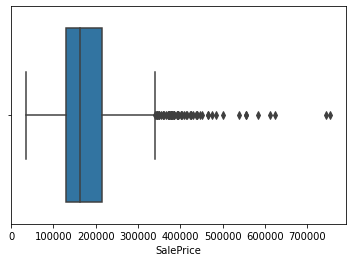

In [13]:
import seaborn as sns
sns.boxplot(x=train_df['SalePrice'])

<AxesSubplot:ylabel='Frequency'>

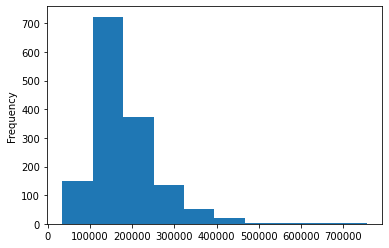

In [14]:
train_df['SalePrice'].plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

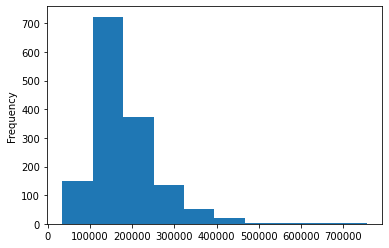

In [15]:
train_df['SalePrice'].plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

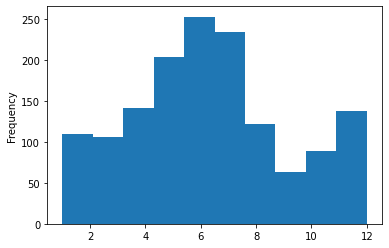

In [16]:
train_df_orig['MoSold'].plot(kind="hist")